In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_row',10)
plt.rcParams["figure.figsize"] = (11,8)

# Численное решение краевой задачи для ОДУ

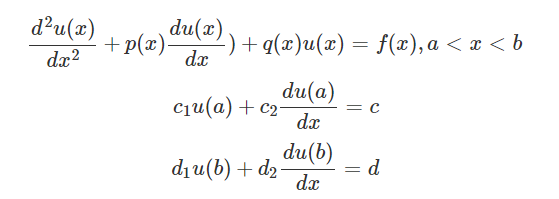

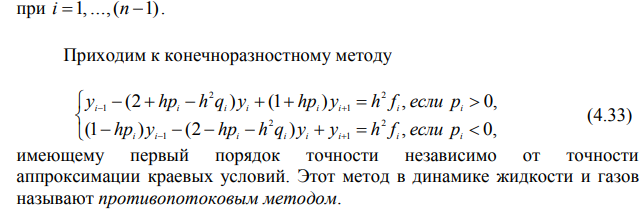

### Далее, чтобы избежать путаницы в обозначениях:
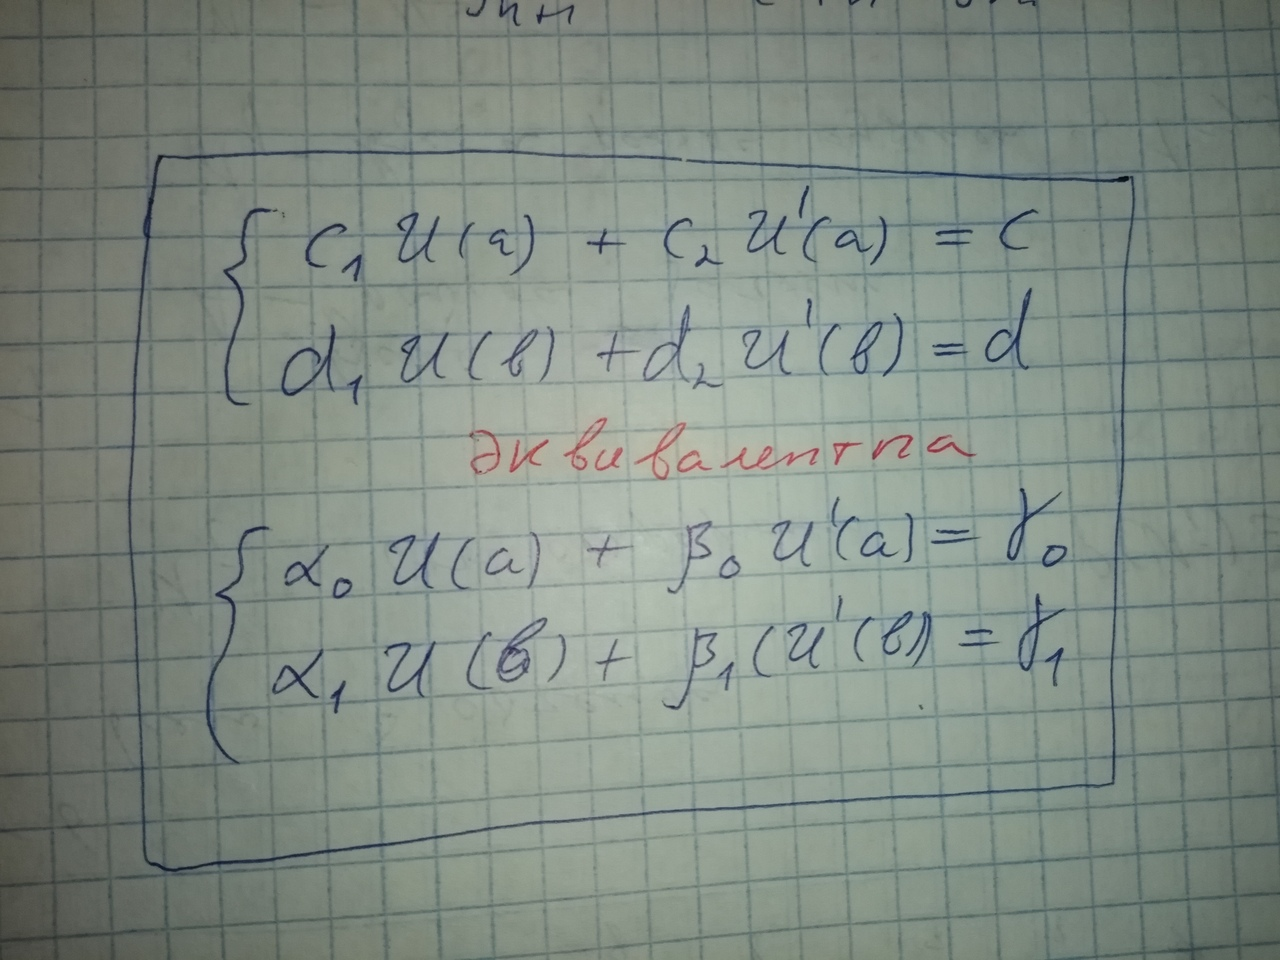

### добавляем уравнения, аппроксимирующие краевые условия

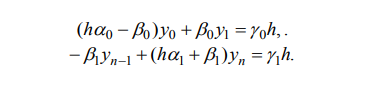

# К методу прогонки:

### приводим краевые условие, что выше, к следующему виду

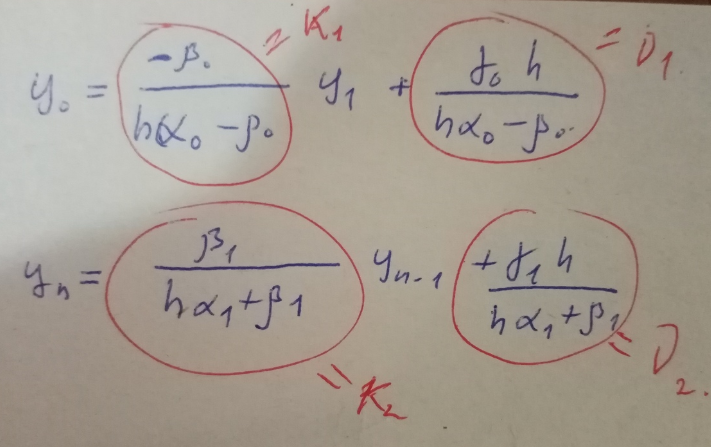

### и далее решаем вот так

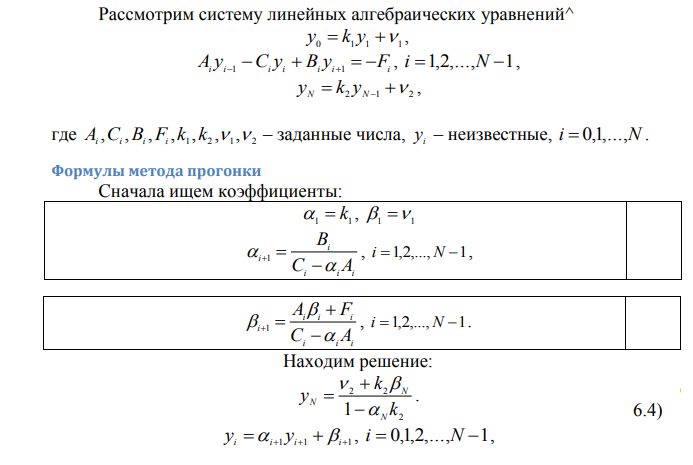

In [2]:
def sweep(a,b,c,f,k1,k2,nu1,nu2):
    # решает слау с трехдиагональной матрицей
    alpha = [k1]
    beta = [nu1]
    n = len(f)
    x = np.zeros(n)
    for i in range(n-1):
        alpha.append(b[i]/(-a[i]*alpha[i] + c[i]))
        beta.append((f[i] + a[i]*beta[i])/(-a[i]*alpha[i] + c[i]))

    x[n-1] = (nu2 + k2*beta[len(beta) - 1])/(1-alpha[len(alpha) - 1]*k2)
    for i in reversed(range(n-1)):
        x[i] = alpha[i+1]*x[i+1] + beta[i+1]
    return x

In [3]:
def SoBoVaP(p,q,f,a,b,c,d,c1,c2,d1,d2, n = 100):
    """
    difference approximation method.
    gives a solution of a boundary value problem like:
    
    u" + p(x)*u' + q(x)*u = f(x)
    c1*u(a) + c2*u'(a) = c
    d1*u(b) + d2*u'(b) = d
    """
    def counterstreamCoef(pi,qi,fi,h,kind):
        # возвращает коэффициенты трехдиагональной матрицы
        if kind == 'A':
            if pi > 0: return 1
            else: return (1-h*pi)
        elif kind == 'C':
            if pi > 0: return (2+h*pi-h**2*qi)
            else: return (2-h*pi-h**2*qi)
        elif kind == 'B':
            if pi > 0: return (1+h*pi)
            else: return 1
        elif kind == 'F':
            return -h**2*fi
            
    x = np.linspace(a,b,n)
    h = x[1] - x[0]
    p = np.array([p(i) for i in x])
    q = np.array([q(i) for i in x])
    f = np.array([-h**2*f(i) for i in x])
    
    A = [counterstreamCoef(p[i],q[i],f[i],h,'A') for i in range(n)]
    B = [counterstreamCoef(p[i],q[i],f[i],h,'B') for i in range(n-1)]
    C = [counterstreamCoef(p[i],q[i],f[i],h,'C') for i in range(n-1)]
    k1 = -c2/(h*c1-c2)
    k2 = d2/(h*d1+d2)
    nu1 = c/(h*c1-c2)
    nu2 = d/(h*d1+d2)
    
    ures = sweep(A,B,C,f,k1,k2,nu1,nu2)
    
    SoBoVaP.score = {'первое краевое(погрешность)': ures[0] * (h*c1-c2) + ures[1]*c2 - c*h,
                     'второе краевое(погрешность)' : -d2*ures[n-2] + ures[n-1]*(h*d1+d2)- d*h}
    plt.plot(x,ures)
    return ures

In [4]:
p = lambda x: -x**2+3*x-2
q = lambda x: np.cos(x)
f = lambda x: np.cos(x)**2
a,b = 1,2
c1,c2,c = -1,0.3,0
d1,d2,d = 0.17,0.19,0

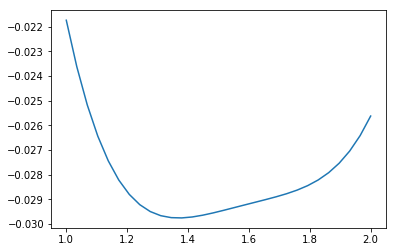

In [5]:
n =30
sol_1 = SoBoVaP(p,q,f,a,b,c,d,c1,c2,d1,d2,n)

In [6]:
SoBoVaP.score

{'первое краевое(погрешность)': 0.00018562340021346935,
 'второе краевое(погрешность)': 0.0}

# Метод дифференциальной прогонки

In [7]:
class disсfoo:
    def __init__(self,w,y):
        self.w = w
        self.y = y
    def __call__(self, x):
        return self.y[np.where(self.w == x)][0]
    
def euler(du,u0,w):
    '''
    численное решение задачи Коши для ОДУ на отрезке [a,b] по правилу Эйлера
    Возвращает: res - вычисленное значение решения в узлах
    '''
    
    n = len(w)
    h = w[1]-w[0]
    res = np.zeros(n)
    res[0] = u0
    i = 1
    while n-i>0:
        res[i] = res[i-1] - h*du(w[i-1],res[i-1])
        i += 1
    return res

In [8]:


def rungekutSys(du,u0,w):
    '''
    численное решение ОДУ на отрезке [a,b] по правилу Рунге-Кута (четырех-шажному)
    РАБОТАЕТ, КАК ЧАСЫ!
    du - система уравнений (любой длины)
    u0 - вектор начальных условий
    '''
    
    n = len(w)
    m = len(du)
    h = w[1]-w[0]
    res = np.zeros((m,n))
    res[:,0] = u0
    j = 1
    while n-j>0:
        args = tuple([res[i,j-1] for i in range(m)])
        K1_v = np.array([du[i](w[j-1], *args) for i in range(m)])
            
        args = tuple([res[i,j-1] + K1_v[i]*h/2 for i in range(m)])
        K2_v = np.array([du[i](w[j-1] + h/2, *args) for i in range(m)])
            
        args = tuple([res[i,j-1] + K2_v[i]*h/2 for i in range(m)])
        K3_v = np.array([du[i](w[j-1] + h/2, *args) for i in range(m)])
            
        args = tuple([res[i,j-1] + K3_v[i]*h for i in range(m)])
        K4_v = np.array([du[i](w[j-1] + h, *args) for i in range(m)])
            
        res[:,j] = np.array([res[i,j-1] + h/6*(K1_v[i] + 2*K2_v[i] + 2*K3_v[i] + K4_v[i]) for i in range(m)])
        j += 1 
    return res

In [33]:


def difsweep(p,q,f,a,b,c,d,c1,c2,d1,d2, n = 100):
    """
    difference sweep method.
    gives a solution of a boundary value problem like:
    
    u" + p(x)*u' + q(x)*u = f(x)
    c1*u(a) + c2*u'(a) = c
    d1*u(b) + d2*u'(b) = d
    """
    def difsweep_1(p,q,f,a,b,c,d,c1,c2,d1,d2, n = 100):
        '''
        if c2 != 0
        '''
        dy1 = lambda x, y1, y2: -y1**2 - p(x)*y1 - q(x)
        dy2 = lambda x, y1, y2: -(y1 + p(x))*y2 + f(x)
        y10 = -c1/c2
        y20 = c/c2
        w = np.linspace(a,b,n)
        Y = rungekutSys([dy1,dy2], np.array([y10,y20]),w)
        y1 = disсfoo(w,Y[0])
        y2 = disсfoo(w,Y[1])
        
        du = lambda x,u: y1(x)*u + y2(x)
        u0 = (d - d2*y2(b))/(d1 + d2*y1(b))
        u = np.flip(euler(du,u0,np.flip(w,axis = 0)),axis = 0)
        
        return u
        
    def difsweep_2(p,q,f,a,b,c,d,c1,c2,d1,d2, n = 100):
        '''
        if c1 != 0
        '''
        dz1 = lambda x, z1, z2: q(x)*z1**2 + p(x)*z1 + 1 
        dz2 = lambda x, z1, z2: q(x)*z1*z2 - f(x)*z1
        z10 = -c2/c1
        z20 = c/c1
        w = np.linspace(a,b,n)
        Z = rungekutSys([dz1,dz2], np.array([z10,z20]),w)
        z1 = disсfoo(w,Z[0])
        z2 = disсfoo(w,Z[1])
        
        du = lambda x,u: z1(x)*u + z2(x)
        u0 = (d - d2*z2(b))/(d1 + d2*z1(b))
        u = np.flip(euler(du,u0,np.flip(w,axis = 0)),axis = 0)
        
        return u
    
    
    
    if c2 != 0: 
        res = difsweep_1(p,q,f,a,b,c,d,c1,c2,d1,d2, n)
    elif c1 != 0: 
        res = difsweep_2(p,q,f,a,b,c,d,c1,c2,d1,d2, n)
    h = (b-a)/n
    difsweep.score = {'первое краевое(погрешность)': res[0] * (h*c1-c2) + res[1]*c2 - c*h,
                     'второе краевое(погрешность)' : -d2*res[n-2] + res[n-1]*(h*d1+d2)- d*h}
    return res
    

In [34]:
p = lambda x: -x**2+3*x-2
q = lambda x: np.cos(x)
f = lambda x: np.cos(x)**2
a,b = 1,2
c1,c2,c = -1,0.3,0
d1,d2,d = 0.17,0.19,0

In [35]:
n =30
sol_2 = difsweep(p,q,f,a,b,c,d,c1,c2,d1,d2,n)

In [29]:
df = pd.DataFrame({'x': np.linspace(a,b,n),
                  'Метод разностной аппроксимации': sol_1,
                  'Метод дифференциальной прогонки': sol_2,
                  'Абсолютная разность решений': np.abs(sol_1 - sol_2)})

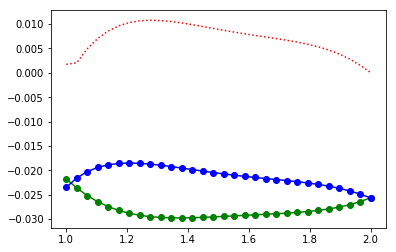

In [19]:
plt.plot(df['x'], df['Абсолютная разность решений'],'r:',
         df['x'], df['Метод разностной аппроксимации'],'go-',
         df['x'], df['Метод дифференциальной прогонки'],'bo-')

### Погрешность разностной аппроксимации на краях:

In [20]:
SoBoVaP.score

{'первое краевое(погрешность)': 0.00018562340021346935,
 'второе краевое(погрешность)': 0.0}

### Погрешность дифференциальной прогонки на краях:

In [21]:
difsweep.score

{'первое краевое(погрешность)': 0.0013516080793097704,
 'второе краевое(погрешность)': -0.0002958476077507561}

In [22]:
df

,x,Метод разностной аппроксимации,Метод дифференциальной прогонки,Абсолютная разность решений
0,1.000000,-0.021744,-0.023463,0.001719
1,1.034483,-0.023624,-0.021564,0.002060
2,1.068966,-0.025178,-0.020256,0.004922
3,1.103448,-0.026440,-0.019391,0.007049
4,1.137931,-0.027443,-0.018861,0.008581
...,...,...,...,...
25,1.862069,-0.027921,-0.023246,0.004676
26,1.896552,-0.027538,-0.023683,0.003855
27,1.931034,-0.027046,-0.024218,0.002828
28,1.965517,-0.026418,-0.024870,0.001548
